In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import (running_mean_APWP, running_mean_APWP_shape, RM_stats, get_pseudo_vgps,
                                  running_mean_VGPs_bootstrapped, running_mean_bootstrapping_direction)

from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, PC
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [6]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(current_path +'/data/df_pole_compilation_by_study.csv')

## Set the hyperparameters for further comparissons.

In [22]:
min_age = 0
max_age = 65
window_length = 23
time_step = 5
# define a list to store all the models
models = []

### 1. Running means classic approach on poles

In [10]:
RM_1_classic_by_study = running_mean_APWP (df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic_by_study['method'] = "RM_classic"
models.append(RM_1_classic_by_study)
RM_1_classic_by_study.head(5)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
1,10.0,15.0,15.0,157.806367,3.053286,6.447966,-67.163587,-87.015353,RM_classic
2,20.0,4.0,4.0,694.396487,3.489190,3.073840,-15.989200,-81.836813,RM_classic
3,30.0,7.0,7.0,460.397603,2.816323,3.775013,-28.128989,-82.900850,RM_classic
4,40.0,8.0,8.0,254.364022,3.479776,5.078754,-28.898450,-83.239212,RM_classic


### 2. Running means ensemble from pseudo-VGPs approach (Vaes et al. 2022)

In [23]:
%%time
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP_shape(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i

    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)
RM_2_ensemble_pseudoVGP['plon'] = RM_2_ensemble_pseudoVGP.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    
RM_2_ensemble_pseudoVGP['method'] = "RM_pseudoVGPs_ensemble"
models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 28.7 s, sys: 179 ms, total: 28.9 s
Wall time: 28.9 s


Set quantiles

In [24]:
RM_2_quantiles_plat = quantiles(RM_2_ensemble_pseudoVGP,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_2_quantiles_plon = quantiles(RM_2_ensemble_pseudoVGP,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_2_ensemble_pseudoVGP.head(3)

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,method
0,0,15.0,21.299026,1.720005,17.551133,0.0,329.0,-39.688130,-86.466356,0.178871,0.553645,3.095223,0.732516,RM_pseudoVGPs_ensemble
1,0,16.0,20.197856,1.690451,18.02322,5.0,360.0,-40.648314,-86.477151,0.220881,0.545402,2.469207,0.766284,RM_pseudoVGPs_ensemble
2,0,19.0,18.513338,1.615115,18.825333,10.0,432.0,-27.970030,-85.431693,0.191487,0.557091,2.909282,0.748578,RM_pseudoVGPs_ensemble


## 3. Running means on VGPs. 
Three different approachs as follows:
### 3.1. Running means on the computed dataset (one run and A95)

In [25]:
RM_31_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_31_on_VGP['method'] = "RM_classic_VGPs"
models.append(RM_31_on_VGP)

In [26]:
RM_31_on_VGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat,method
0,0.0,308.0,15.0,22.847346,1.713794,16.945998,-45.430085,-88.076649,RM_classic_VGPs
1,5.0,310.0,15.0,22.741800,1.712371,16.985276,-45.145112,-87.982941,RM_classic_VGPs
2,10.0,349.0,17.0,21.923213,1.644685,17.299475,-31.896117,-87.275556,RM_classic_VGPs


### 3.2. Running means on random samples (with replacement) from the original dataset to generate an ensemble of possible solution.

In [27]:
%%time
RM_32_boots_VGPs=running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_32_boots_VGPs['method']="RM_bootstrapped_VGPs_ensemble"
models.append(RM_32_boots_VGPs)

CPU times: user 14.4 s, sys: 113 ms, total: 14.5 s
Wall time: 14.6 s


Set quantiles

In [28]:
RM_32_quantiles_plat = quantiles(RM_32_boots_VGPs,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_32_quantiles_plon = quantiles(RM_32_boots_VGPs,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_32_boots_VGPs.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,288.0,21.452094,1.832061,17.488404,0.291192,0.630837,2.166399,0.922029,0.0,15.0,-51.856171,-86.611353,RM_bootstrapped_VGPs_ensemble
1,0.0,293.0,20.977062,1.837748,17.68531,0.320265,0.584504,1.825064,0.904769,5.0,15.0,-50.815029,-86.215879,RM_bootstrapped_VGPs_ensemble
2,0.0,332.0,21.266985,1.713534,17.564349,0.262632,0.587776,2.238017,0.850408,10.0,17.0,-39.943320,-85.858235,RM_bootstrapped_VGPs_ensemble


### 3.3. Propation of directional error towards the VGP level. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [29]:
%%time
RM_33_propagation=running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)
RM_33_propagation['method']="RM_DirErrorPropagated_ensemble"
models.append(RM_33_propagation)

CPU times: user 45.3 s, sys: 276 ms, total: 45.6 s
Wall time: 45.6 s


Set quantiles

In [30]:
RM_33_quantiles_plat = quantiles(RM_33_propagation,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_33_quantiles_plon = quantiles(RM_33_propagation,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
RM_33_propagation.head(3)

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,n_studies,plon,plat,method
0,0.0,291.0,16.429704,2.098274,19.983435,0.13353,0.645938,4.837398,0.779468,0.0,14.0,-5.836269,-88.653878,RM_DirErrorPropagated_ensemble
1,0.0,294.0,16.432633,2.087289,19.981654,0.119518,0.656571,5.493516,0.776089,5.0,15.0,-8.854118,-88.534319,RM_DirErrorPropagated_ensemble
2,0.0,330.0,16.429813,1.96979,19.983369,0.109447,0.667899,6.102473,0.777346,10.0,18.0,-22.965424,-88.000721,RM_DirErrorPropagated_ensemble


## Get APW from Muller et al., 2016 and Torsvik and Cocks, 2017

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211
- Torsvik, T. H., & Cocks, L. R. M. (2013). Gondwana from top to base in space and time. Gondwana Research, 24(3-4), 999-1030.


In [31]:
Torsvik2017_path = np.loadtxt('model_APWP/code_output/NAM_0_60_torsvik_2017.txt', )
Torsvik2017_path_df = pd.DataFrame(Torsvik2017_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Torsvik2017_path_df = Torsvik2017_path_df[Torsvik2017_path_df['age']>0]
Torsvik2017_path_df['method'] = "plate model"
models.append(Torsvik2017_path_df)

Mueller2016_path = np.loadtxt('model_APWP/code_output/NAM_0_60_muller_2016.txt', )
Mueller2016_path_df = pd.DataFrame(Mueller2016_path, columns = ['age','plon', 'plat', 'Euler_angle', 'Euler_lon', 'Euler_lat'])
Mueller2016_path_df = Mueller2016_path_df[Mueller2016_path_df['age']>0]
Mueller2016_path_df['method']="plate model"
models.append(Mueller2016_path_df)

Merge

In [32]:
df_all = pd.concat(models, axis=0)
df_all.head()

,run,n_studies,k,A95,csd,age,N,plon,plat,foliation,lineation,collinearity,coplanarity,method,Euler_angle,Euler_lon,Euler_lat
0,0,15.0,21.299026,1.720005,17.551133,0.0,329.0,-39.688130,-86.466356,0.178871,0.553645,3.095223,0.732516,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
1,0,16.0,20.197856,1.690451,18.02322,5.0,360.0,-40.648314,-86.477151,0.220881,0.545402,2.469207,0.766284,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
2,0,19.0,18.513338,1.615115,18.825333,10.0,432.0,-27.970030,-85.431693,0.191487,0.557091,2.909282,0.748578,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
3,0,13.0,13.937001,2.219821,21.697033,15.0,310.0,-10.201933,-85.009971,0.065555,0.544506,8.306084,0.610061,RM_pseudoVGPs_ensemble,NaN,NaN,NaN
4,0,9.0,12.01779,2.42112,23.365372,20.0,306.0,-16.424040,-82.582295,0.019532,0.616828,31.581173,0.63636,RM_pseudoVGPs_ensemble,NaN,NaN,NaN


# Comparisons plot

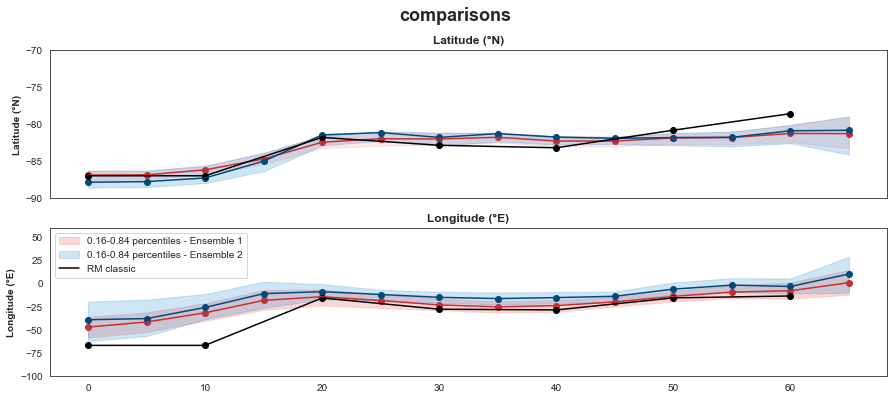

In [33]:
title = "comparisons"

df_method1=RM_2_ensemble_pseudoVGP
df_method2=RM_33_propagation

ensemble1_lat = quantiles(df_method1,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble1_lon = quantiles(df_method1,"age","plon") # set quantiles of longitude groupedby age for visualization purposes
ensemble2_lat = quantiles(df_method2,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
ensemble2_lon = quantiles(df_method2,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-70)
axes[1].set_ylim(-100,60)
# LATITUDE
axes[0].fill_between(ensemble1_lat.X, ensemble1_lat.q16,ensemble1_lat.q84, color= "#f98787", alpha=.20)
axes[0].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")
axes[0].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[1],color="#d12a2a")

axes[0].fill_between(ensemble2_lat.X, ensemble2_lat.q16,ensemble1_lat.q84, color= "#0E7DC9", alpha=.20)
axes[0].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")
axes[0].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[1],color="#00497A")

axes[0].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plat, color="black") #CLASSIC


# # LONGITUDE
axes[1].fill_between(ensemble1_lon.X, ensemble1_lon.q16,ensemble1_lon.q84, color= "#f9afaf", alpha=.50,label="0.16-0.84 percentiles - Ensemble 1")
axes[1].plot(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0], '-',color="#d12a2a")
axes[1].scatter(PC(df_method1,"age","plat","plon").X, PC(df_method1,"age","plat","plon").PC()[0],color="#d12a2a")

axes[1].fill_between(ensemble2_lon.X, ensemble2_lon.q16,ensemble2_lon.q84, color= "#0E7DC9", alpha=.20,label="0.16-0.84 percentiles - Ensemble 2")
axes[1].plot(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0], '-',color="#00497A")
axes[1].scatter(PC(df_method2,"age","plat","plon").X, PC(df_method2,"age","plat","plon").PC()[0],color="#00497A")
axes[1].plot(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, '-',color="black", label = "RM classic") #CLASSIC
axes[1].scatter(RM_1_classic_by_study.age, RM_1_classic_by_study.plon, color="black") #CLASSIC

plt.legend(loc="upper left")

# APWPs vs Plate Models Visualizations

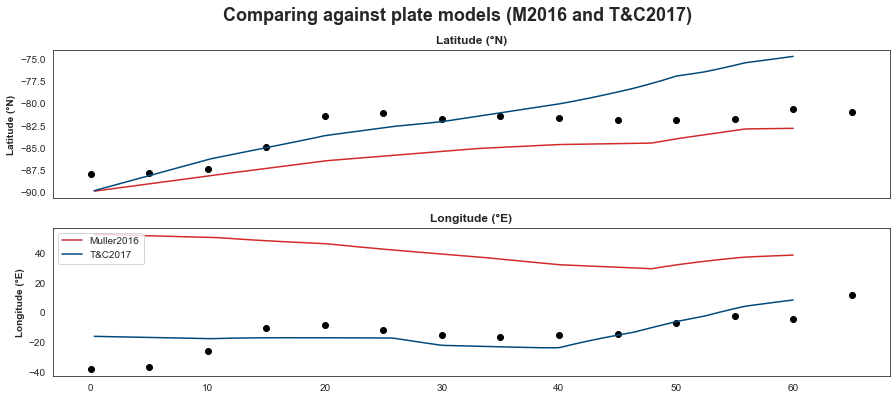

In [34]:
title = "Comparing against plate models (M2016 and T&C2017)"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')
# LATITUDE

axes[0].plot(Mueller2016_path_df.age, Mueller2016_path_df.plat, '-',color="#d12a2a")
# axes[0].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plat,s = 1, color="#d12a2a")
axes[0].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, '-',color="#00497A") #CLASSIC
# axes[0].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plat, color="#00497A") #CLASSIC
axes[0].scatter(ensemble2_lat.X, ensemble2_lat.q50,color="black")
# LONGITUDE

axes[1].plot(Mueller2016_path_df.age, Mueller2016_path_df.plon, '-',color="#d12a2a", label = "Muller2016")
# axes[1].scatter(Mueller2016_path_df.age, Mueller2016_path_df.plon,color="#d12a2a")
axes[1].plot(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, '-',color="#00497A", label = "T&C2017") #CLASSIC
# axes[1].scatter(Torsvik2017_path_df.age, Torsvik2017_path_df.plon, color="#00497A") #CLASSIC
axes[1].scatter(ensemble2_lon.X, ensemble2_lon.q50,color="black")

# axes[1].set_ylim(-100, 50)
plt.legend(loc="upper left")